# Using pre-trained NN

In [108]:
import numpy as np
import tensorflow as tf
import keras
from IPython.display import Image
from matplotlib import pyplot as plt
from imageio import imread
import pickle

# Model Zoo
* https://github.com/keras-team/keras/tree/master/keras/applications
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

#### Very Deep Convolutional Networks for Large-Scale Visual Recognition
VGG at Oxford: http://www.robots.ox.ac.uk/~vgg/research/very_deep/
<br>
### [layer configuration](https://gist.githubusercontent.com/ksimonyan/211839e770f7b538e2d8/raw/0067c9b32f60362c74f4c445a080beed06b07eb3/VGG_ILSVRC_16_layers_deploy.prototxt)
Build a model based on **layer configuration** below

In [3]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten # You may need this :)

In [4]:
img_input = Input(shape=(224, 224, 3), name="input")
#first
x = Conv2D(64, 3, padding = "same", name = "conv1_1")(img_input)
x = Activation('relu', name = 'relu1_1')(x)
x = Conv2D(64, 3, padding = "same", name = "conv1_2")(x)
x = Activation('relu', name = 'relu1_2')(x)
x = MaxPool2D((2,2),(2,2),padding = 'same', name = 'pool1')(x)

#second
x = Conv2D(128, 3, padding = "same", name = "conv2_1")(x)
x = Activation('relu', name = 'relu2_1')(x)
x = Conv2D(128, 3, padding = "same", name = "conv2_2")(x)
x = Activation('relu', name = 'relu2_2')(x)
x = MaxPool2D((2,2),(2,2),padding = 'same', name = 'pool2')(x)

#thrid
x = Conv2D(256, 3, padding = "same", name = "conv3_1")(x)
x = Activation('relu', name = 'relu3_1')(x)
x = Conv2D(256, 3, padding = "same", name = "conv3_2")(x)
x = Activation('relu', name = 'relu3_2')(x)
x = Conv2D(256, 3, padding = "same", name = "conv3_3")(x)
x = Activation('relu', name = 'relu3_3')(x)
x = MaxPool2D((2,2),(2,2),padding = 'same', name = 'pool3')(x)

#forth
x = Conv2D(512, 3, padding = "same", name = "conv4_1")(x)
x = Activation('relu', name = 'relu4_1')(x)
x = Conv2D(512, 3, padding = "same", name = "conv4_2")(x)
x = Activation('relu', name = 'relu4_2')(x)
x = Conv2D(512, 3, padding = "same", name = "conv4_3")(x)
x = Activation('relu', name = 'relu4_3')(x)
x = MaxPool2D((2,2),(2,2),padding = 'same', name = 'pool4')(x)

#fifth
x = Conv2D(512, 3, padding = "same", name = "conv5_1")(x)
x = Activation('relu', name = 'relu5_1')(x)
x = Conv2D(512, 3, padding = "same", name = "conv5_2")(x)
x = Activation('relu', name = 'relu5_2')(x)
x = Conv2D(512, 3, padding = "same", name = "conv5_3")(x)
x = Activation('relu', name = 'relu5_3')(x)
x = MaxPool2D((2,2),(2,2),padding = 'same', name = 'pool5')(x)

#flatten
x = Flatten()(x)

#Denses
x = Dense(4096, name = 'fc6')(x)
x = Activation('relu', name = 'relu6')(x)
x = Dropout(0.5, name = 'drop6')(x)

x = Dense(4096, name = 'fc7')(x)
x = Activation('relu', name = 'relu7')(x)
x = Dropout(0.5, name = 'drop7')(x)

x = Dense(1000, name = 'fc8')(x)
x = Activation("softmax", name = "prob")(x)

model = keras.Model(img_input, x)

You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 224, 224, 3). Without this transformation, vgg16 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [5]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img_new = np.array(img).astype(np.float32)
    img_new[:,:,0], img_new[:,:,2] = img[:,:,2], img[:,:,0]
    for i in range(3):
        img_new[:,:,i] -= MEAN_VALUES[i]
    
    img_new = img_new[np.newaxis]
    return img_new

def deprocess(img):
    img = img.reshape(img.shape[1:])
    for i in range(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print(np.linalg.norm(deprocess(preprocess(img)) - img))

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [6]:
# load vgg16 weights
import h5py
with h5py.File("vgg16_weights_tf_dim_ordering_tf_kernels.h5", "r") as f:
    vgg16_weights = {k1: {k2:v2.value for k2, v2 in v1.items()} 
                     for k1, v1 in f.items() if len(v1)>0}

/home/nitrov/anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [7]:
[[y.shape for y in x.values()] for x in vgg16_weights.values()]

[[(3, 3, 3, 64), (64,)],
 [(3, 3, 64, 64), (64,)],
 [(3, 3, 64, 128), (128,)],
 [(3, 3, 128, 128), (128,)],
 [(3, 3, 128, 256), (256,)],
 [(3, 3, 256, 256), (256,)],
 [(3, 3, 256, 256), (256,)],
 [(3, 3, 256, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(3, 3, 512, 512), (512,)],
 [(25088, 4096), (4096,)],
 [(4096, 4096), (4096,)],
 [(4096, 1000), (1000,)]]

Now we should put the weights into their places:

In [8]:
vgg_weights = []
[[vgg_weights.append(y) for y in x.values()] for x in vgg16_weights.values()]
model.set_weights(vgg_weights)

In [9]:
# classes' names are stored here
with open("classes.txt", "r") as f:
    classes = f.read().splitlines()
# for example, 10th class is ostrich:
print(classes[9])

ostrich, Struthio camelus


### Sanity check
Lets check that out pretrained network is working. We have sample image of a "albatross" and lets check that out network predicts it well.

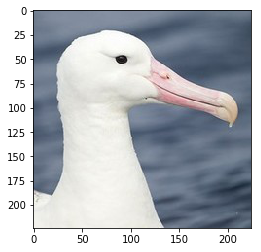

note that image array type is uint8
top-5 classes are:
0.996280	albatross
0.003715	goose
0.000001	drake
0.000001	white stork
0.000001	spoonbill


In [10]:
img = imread('albatross.jpg')
plt.imshow(img)
plt.show()
print("note that image array type is", img.dtype)

p = model.predict(preprocess(np.array(img)))

labels = p.ravel().argsort()[-1:-6:-1]
print('top-5 classes are:')
for l in labels:
    print('%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0]))

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [11]:
from keras import backend as K
featurized =  K.function([model.layers[0].input], [model.layers[-4].output])

In [12]:
X = np.load('X.npy')
X_test = np.load('X_test.npy')
Y = np.load('Y.npy')

In [13]:
dims = int(X.shape[1]**0.5)

In [14]:
X = X.reshape(X.shape[0], 1, dims, dims)
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
one_hot_y = np.array(enc.fit_transform(Y.reshape(-1, 1)).todense())

/home/nitrov/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [15]:
X_train = X[:23000]
y_train = one_hot_y[:23000]
X_val = X[23000:]
y_val = one_hot_y[23000:]

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [75]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [76]:
random_forest = RandomForestClassifier()
ada_boost = AdaBoostClassifier()

In [84]:
random_forest.fit(X_train, y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
val_pred_forest = random_forest.predict(X_val)

In [88]:
from sklearn.metrics import accuracy_score
print("Accuracy on Random Forest is", np.around(accuracy_score(y_val, val_pred_forest)*100, 2), "%")

Accuracy on Random Forest is 96.85 %


# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `mysupermegaoptimizer.minimize(loss, var_list=<only_those_weights_i_wanna_train>)`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * You can have two optimizers: one for old network and one for new network
      * `old_net_optimizer.minimize(loss, old_net_weigts)`
      * `new_net_optimizer.minimize(loss, new_net_weigts)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
      * get test data https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screenshot pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [16]:
print("I can do it!")

I can do it!


In [26]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [27]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

In [28]:
model_feat = Sequential()

model_feat.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,dims,dims)))
model_feat.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model_feat.add(MaxPooling2D(pool_size=(2, 2)))

model_feat.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_feat.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model_feat.add(MaxPooling2D(pool_size=(2, 2)))

model_feat.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model_feat.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model_feat.add(MaxPooling2D(pool_size=(2, 2)))

model_feat.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model_feat.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model_feat.add(MaxPooling2D(pool_size=(2, 2)))

model_feat.add(Flatten())

model_feat.add(Dense(64, activation=swish_activation))
model_feat.add(Dropout(0.4))
model_feat.add(Dense(2 , activation='sigmoid'))

model_feat.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_feat.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 64, 64)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 64, 64)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 32, 32)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 32, 32)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 16, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 16, 16)        55392     
__________

In [29]:
epochs = 20
batch_size = 128
learning_rate = 0.0001
optimizer = Adam(learning_rate)
model_feat.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
model_feat.fit(X_train, y_train, epochs=epochs, batch_size = batch_size)

Epoch 1/20
23000/23000 [==============================] - 429s 19ms/step - loss: 0.1356 - acc: 0.9504
Epoch 2/20
23000/23000 [==============================] - 406s 18ms/step - loss: 0.0850 - acc: 0.9695
Epoch 3/20
23000/23000 [==============================] - 395s 17ms/step - loss: 0.0665 - acc: 0.9765
Epoch 4/20
23000/23000 [==============================] - 312s 14ms/step - loss: 0.0534 - acc: 0.9805
Epoch 5/20
23000/23000 [==============================] - 312s 14ms/step - loss: 0.0487 - acc: 0.9827
Epoch 6/20
23000/23000 [==============================] - 313s 14ms/step - loss: 0.0397 - acc: 0.9860
Epoch 7/20
23000/23000 [==============================] - 313s 14ms/step - loss: 0.0354 - acc: 0.9882
Epoch 8/20
23000/23000 [==============================] - 320s 14ms/step - loss: 0.0298 - acc: 0.9895
Epoch 9/20
23000/23000 [==============================] - 314s 14ms/step - loss: 0.0228 - acc: 0.9924
Epoch 10/20
23000/23000 [==============================] - 312s 14ms/step - loss: 

In [33]:
model_feat.save_weights('vgg/model_feat_wieghts.h5')
model_feat.save('vgg/model_feat_keras.h5')

In [36]:
X_test = X_test.reshape(X_test.shape[0], 1, dims, dims)

In [37]:
prediction_feat = model_feat.predict(X_test, verbose=1)

12500/12500 [==============================] - 114s 9ms/step


In [65]:
val_feat = model_feat.predict(X_val, verbose=1)

2000/2000 [==============================] - 16s 8ms/step


In [72]:
val_score = []
val_target = []
for val1, val2 in zip(val_feat, y_val):
    val_score.append(np.argmax(val1))
    val_target.append(np.argmax(val2))
val_score = np.array(val_score)
val_target = np.array(val_target)

In [73]:
from sklearn.metrics import accuracy_score
print("Accuracy on validation is", np.around(accuracy_score(val_target, val_score)*100, 2), "%")

Accuracy on validation is 98.45 %


In [93]:
prediction_feat = prediction_feat.clip(min = 0.005, max = 0.995)

In [96]:
pred_sub = prediction_feat[:,0]

In [97]:
kaggle_sub = pd.DataFrame({'id': np.arange(1, 12501), 'label': pred_sub})

In [98]:
kaggle_sub.to_csv('data/final_sub.csv', index=False)

<h4>The kaggle Public score was 2.63624</h4>

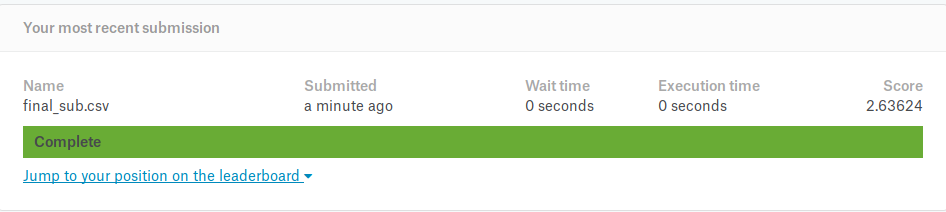

In [107]:
Image("score.png")